# Text Classification: Language Anxiety

## Download Library

In [ ]:
# !pip install wordcloud

## Importing Library

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Bidirectional, Embedding, Dropout, SpatialDropout1D, BatchNormalization
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.utils import shuffle

import keras

from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

import random

import warnings
warnings.filterwarnings('ignore')

## # Set random seed for reproducibility

In [ ]:
seed = 2025
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

## Reading The Dataset

In [ ]:
df = pd.read_excel('/content/dataset_2class_better.xlsx')
# df = df[["Post", "LA Class"]]
df.head()

,shortname,idnumber,firstname,lastname,thread,Post,charcount,wordcount,postdate,id,...,Saya merasa tidak percaya diri dengan keahlian menulis saya dalam Bahasa Inggris,Saya merasa gugup ketika menghadapi test menulis dalam Bahasa Inggris,Saya khawatir komposisi bahasa Inggris saya akan dikritik,Saya merasa malu melihat nilai buruk dari karangan Bahasa Inggris saya,Saya takut teman-teman akan mengkritik hasil tulisan saya dalam Bahasa Inggris,Saya merasa cemas tulisan saya dalam Bahasa Inggris akan tampak lucu,Saya takut menulis kepada penutur asli bahasa Inggris,Kelas,LA MEAN,LA Class
0,UWJXA2-KM-46-GAB0304,1502223094,KHALIESAH,AQILAH,Khaliesah Aqilah,The place I've been to that I love and always ...,502,109,2024-02-27 13:46:10,2541902,...,3,3,3,3,3,3,4,KM-46-04,3.1,Anxiety
1,UWJXA2-KM-46-GAB0304,1502223341,NISRINA,NORAMALIA FITRI,Nisrina Noramalia,"My favorite place is Hat Yai in Thailand, spec...",687,152,2024-02-27 13:53:14,2541929,...,3,3,4,2,2,2,2,KM-46-04,2.5,Anxiety
2,UWJXA2-KM-46-GAB0304,1502223015,KALILA,QUEENTANIA,Kalila Queentania,One of my favorite places that i have been vis...,937,225,2024-02-27 13:53:42,2541930,...,2,3,2,2,3,3,1,km 46-03,2.1,No Anxiety
3,UWJXA2-KM-46-GAB0304,1502223016,RATNA,MEITA ARIANTARI PUTRI,Ratna Meita Ariantari Putri,"When I was in 6th grade, I went on a vacation ...",677,167,2024-02-27 13:53:42,2541931,...,3,3,3,3,3,3,3,KM 46 04,3.0,Anxiety
4,UWJXA2-KM-46-GAB0304,1502223251,NITA,NABILA,Nita Nabila,"My favorite place is Bali, I like Bali so much...",621,151,2024-02-27 13:53:54,2541932,...,3,3,4,4,4,4,3,KM-46-04,3.4,Anxiety


## Exploratory Data Analysis

### Checking Class Distribution

LA Class
Anxiety       225
No Anxiety     99
Name: count, dtype: int64



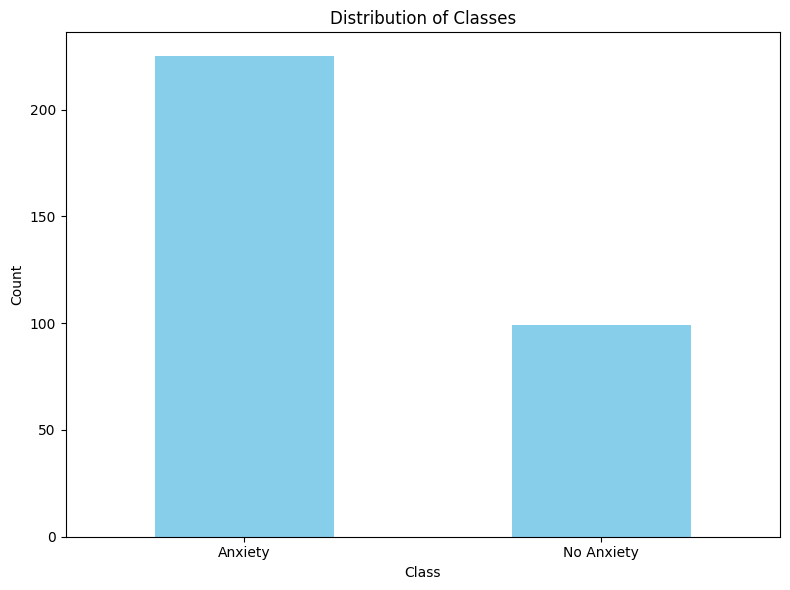

In [ ]:
# Mengambil nilai perhitungan distribusi kelas
class_counts = df['LA Class'].value_counts()
print(class_counts)
print()

# Membuat diagram batang berbeda warna
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Untuk memutar label sumbu x agar lebih mudah dibaca
plt.tight_layout()
plt.show()

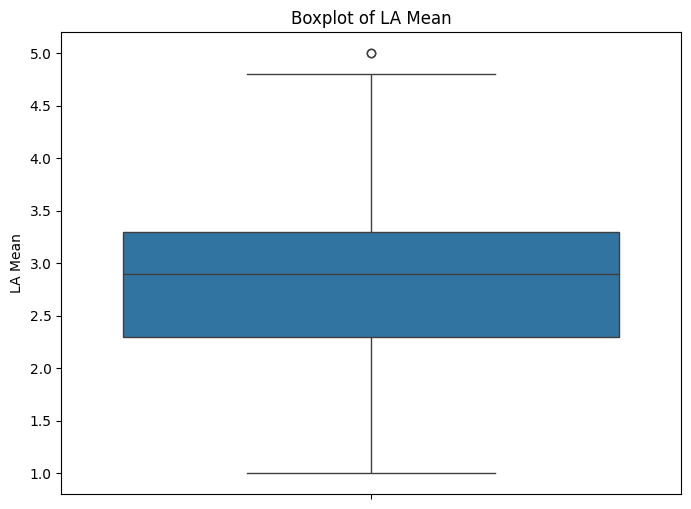

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(y=df['LA MEAN'])
plt.title('Boxplot of LA Mean')
plt.ylabel('LA Mean')
plt.show()

### Distribution of Anxiety by Gender

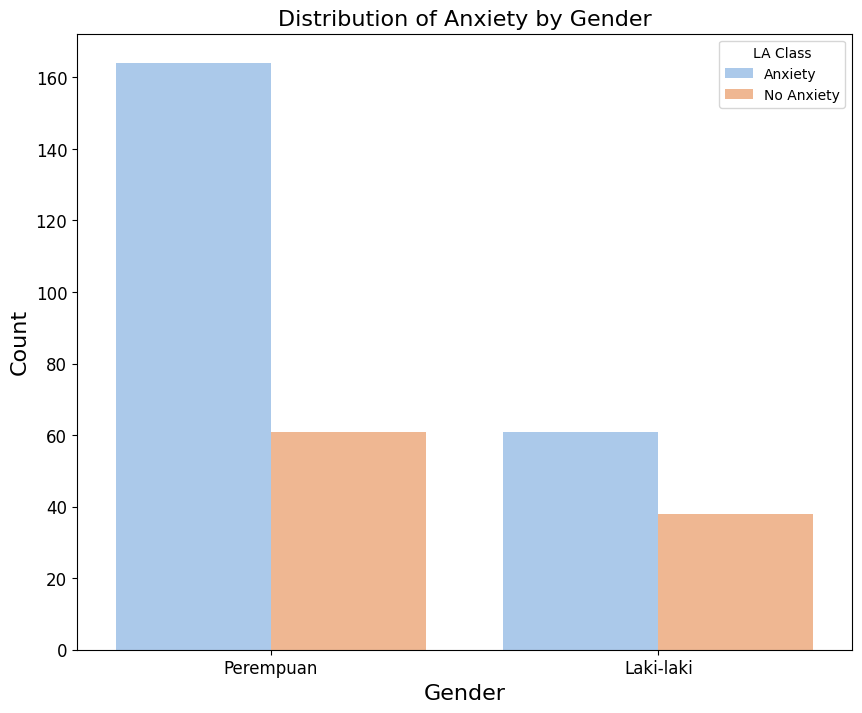

In [ ]:
plt.figure(figsize=(10, 8))
sns.countplot(data=df, x='Jenis Kelamin', hue='LA Class', palette='pastel')  # Skyblue tidak bisa untuk hue multiple, pakai 'pastel'
plt.title('Distribution of Anxiety by Gender', fontsize=16)
plt.xlabel('Gender', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### Essay Length Distribution

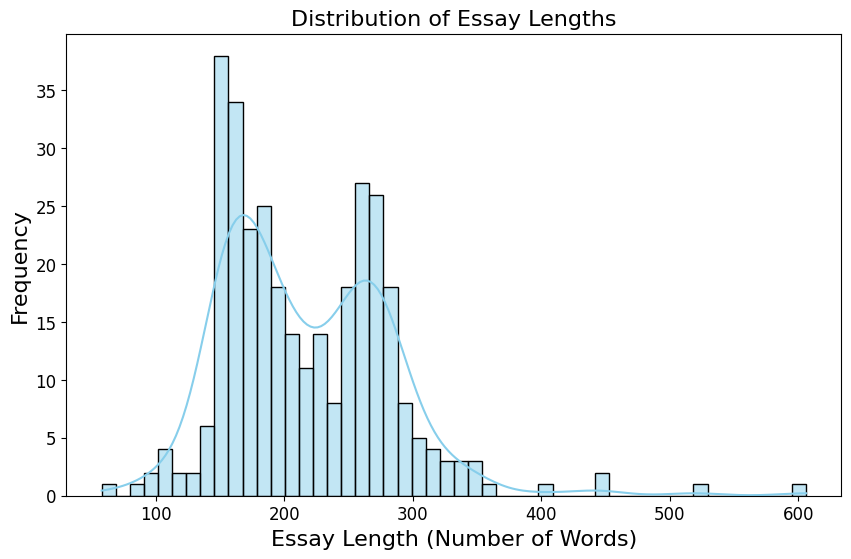

In [ ]:
df['Essay_Length'] = df['Post'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(df['Essay_Length'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Essay Lengths', fontsize=16)
plt.xlabel('Essay Length (Number of Words)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

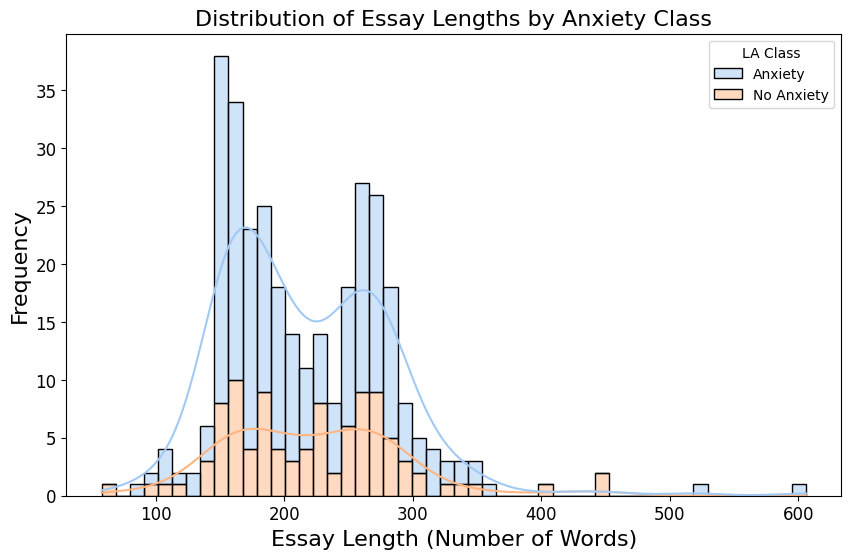

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Essay_Length', hue='LA Class', multiple='stack', bins=50, kde=True, palette='pastel')
plt.title('Distribution of Essay Lengths by Anxiety Class', fontsize=16)
plt.xlabel('Essay Length (Number of Words)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


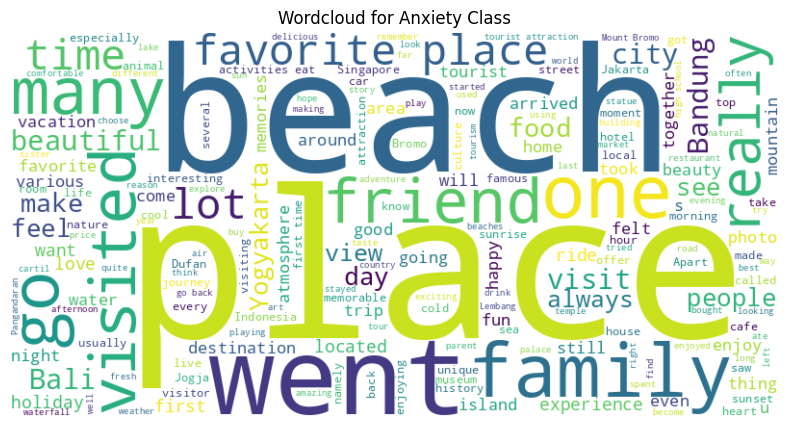

In [ ]:
from wordcloud import WordCloud

# Filter the dataframe to get texts from the 'anxiety' class
anxiety_texts = df[df['LA Class'] == 'Anxiety']['Post']

# Combine all texts into a single string
all_anxiety_text = " ".join(text for text in anxiety_texts)

# Create the WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_anxiety_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud for Anxiety Class')
plt.show()

### Worcloud From Non-Anxious Class Essay

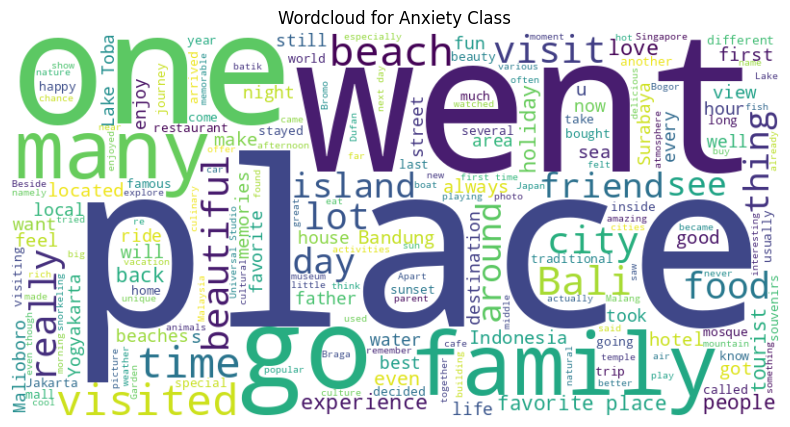

In [ ]:
from wordcloud import WordCloud

# Filter the dataframe to get texts from the 'anxiety' class
anxiety_texts = df[df['LA Class'] == 'No Anxiety']['Post']

# Combine all texts into a single string
all_anxiety_text = " ".join(text for text in anxiety_texts)

# Create the WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_anxiety_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud for Anxiety Class')
plt.show()

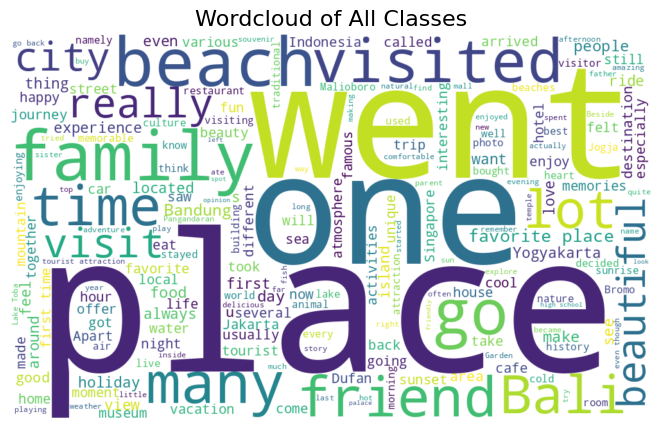

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Gabungkan semua teks dari kolom 'Post'
all_text = " ".join(text for text in df['Post'].dropna())

# Buat wordcloud
wordcloud = WordCloud(width=1000, height=600, background_color='white').generate(all_text)

# Tampilkan wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud of All Classes', fontsize=16)
plt.show()

## Encode Target Variable

In [ ]:
# Menggunakan mapping manual dengan map
df['la_class'] = df['LA Class'].map({'Anxiety': 1, 'No Anxiety': 0})

# Menampilkan hasil
print("Mapping kelas ke nilai encoded:")
print(df[['LA Class', 'la_class']])

# Menghapus kolom asli
df.drop(columns=['LA Class'], inplace=True)

Mapping kelas ke nilai encoded:
       LA Class  la_class
0       Anxiety         1
1       Anxiety         1
2    No Anxiety         0
3       Anxiety         1
4       Anxiety         1
..          ...       ...
319     Anxiety         1
320     Anxiety         1
321  No Anxiety         0
322     Anxiety         1
323     Anxiety         1

[324 rows x 2 columns]


## Data Cleaning

### Contraction Mapping

In [ ]:
contraction_mapping = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he had",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how does",
    "I'd": "I had",
    "I'd've": "I would have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it'd": "it had",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she had",
    "she'd've": "she would have",
    "she'll": "she she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that had",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there had",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they had",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
}

def expand_contractions(text, contraction_mapping):
    for contraction, expanded in contraction_mapping.items():
        text = text.replace(contraction, expanded)
    return text

df['Post'] = df['Post'].apply(lambda x: expand_contractions(x, contraction_mapping))

### Cleaning The Text

In [ ]:
import re
import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
english_stopwords = stopwords.words('english')
kata_negasi_english = [
    'not', 'no', 'don', 'don\'t', 'doesn', 'doesn\'t', 'didn', 'didn\'t', 'haven', 'haven\'t',
    'hasn', 'hasn\'t', 'hadn', 'hadn\'t', 'won', 'won\'t', 'wouldn', 'wouldn\'t', 'can', 'can\'t',
    'couldn', 'couldn\'t', 'shouldn', 'shouldn\'t', 'mightn', 'mightn\'t', 'mustn', 'mustn\'t',
    'never', 'none', 'nobody', 'nothing', 'nowhere', 'hardly', 'scarcely', 'barely', 'without', 'neither', 'nor'
]
english_stopwords = {word for word in english_stopwords if word not in kata_negasi_english}

lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Hapus karakter non-alphanumeric
    text = re.sub('[^a-zA-Z]', ' ', text)
    # Konversi teks ke huruf kecil
    text = text.lower()
    # Split teks menjadi kata-kata
    words = text.split()
    # Lematisasi dan hapus stop words
    words = [lemmatizer.lemmatize(word) for word in words if word not in set(english_stopwords)]
    # Gabungkan kata-kata kembali menjadi satu string
    processed_text = ' '.join(words)

    return processed_text

df['Post'] = df['Post'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Outlier Removal

Original DataFrame shape: (324, 26)
Cleaned DataFrame shape after removing outliers: (322, 26)


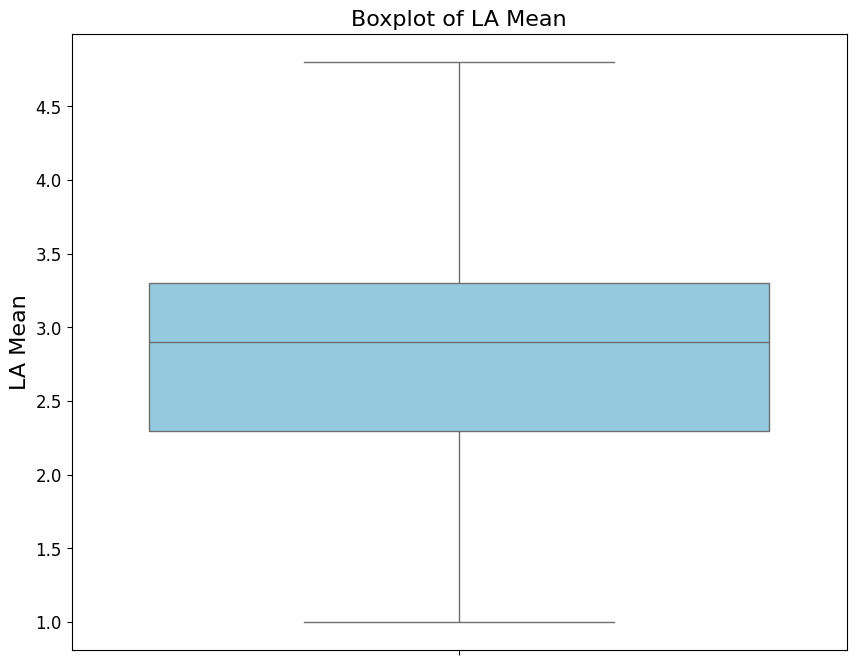

In [ ]:
# Remove outliers based on the 'LA MEAN' column
# Calculate Q1, Q3, and IQR
Q1 = df['LA MEAN'].quantile(0.25)
Q3 = df['LA MEAN'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
df_cleaned = df[(df['LA MEAN'] >= lower_bound) & (df['LA MEAN'] <= upper_bound)].copy()

print("Original DataFrame shape:", df.shape)
print("Cleaned DataFrame shape after removing outliers:", df_cleaned.shape)

# You can replace the original dataframe with the cleaned one if needed
df = df_cleaned

# Visualize the data after removing outliers
plt.figure(figsize=(10, 8))
sns.boxplot(y=df['LA MEAN'], color='skyblue')
plt.title('Boxplot of LA Mean', fontsize=16)
plt.ylabel('LA Mean', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

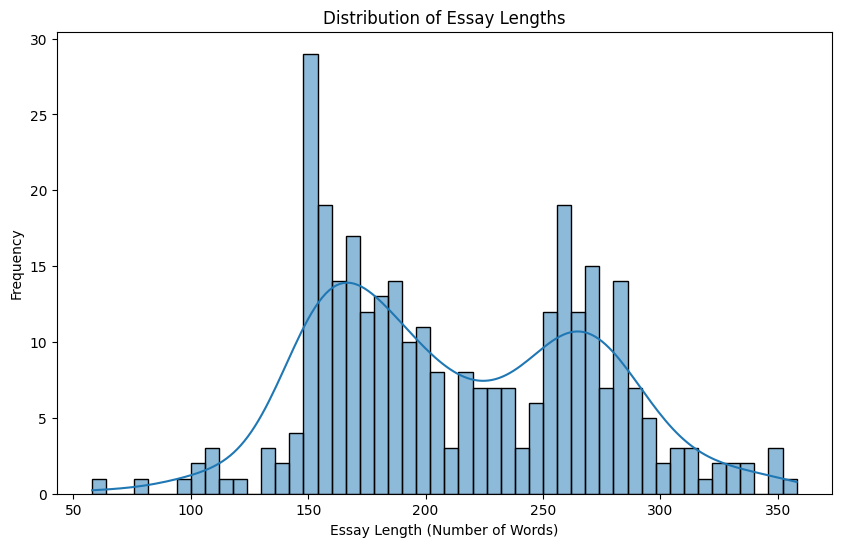

In [ ]:
# prompt: Delete row with Essay_Length >= 400

df = df[df['Essay_Length'] < 400]

plt.figure(figsize=(10, 6))
sns.histplot(df['Essay_Length'], bins=50, kde=True)
plt.title('Distribution of Essay Lengths')
plt.xlabel('Essay Length (Number of Words)')
plt.ylabel('Frequency')
plt.show()

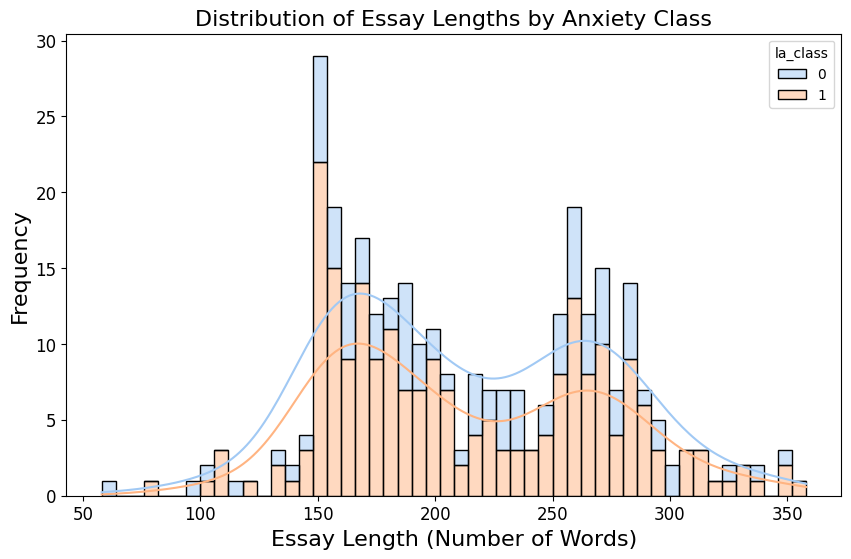

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Essay_Length', hue='la_class', multiple='stack', bins=50, kde=True, palette='pastel')
plt.title('Distribution of Essay Lengths by Anxiety Class', fontsize=16)
plt.xlabel('Essay Length (Number of Words)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Splitting The Dataset Into Train And Test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['Post'], df['la_class'], test_size = 0.20, stratify = df['la_class'], random_state = 42)

## Hyperparameter

In [ ]:
max_len = 100
vocab_size = 2000
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

## Tokenizing

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size,
                      char_level = False,
                      oov_token = oov_tok)
tokenizer.fit_on_texts(X_train)

## Get The Word Index

In [ ]:
word_index = tokenizer.word_index
total_words = len(word_index)
total_words

4197

## Creating Train Sequences

In [ ]:
training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences,
                                maxlen = max_len,
                                padding = padding_type,
                                truncating = trunc_type)

## Creating Test Sequences

In [ ]:
testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences,
                               maxlen = max_len,
                               padding = padding_type,
                               truncating = trunc_type)

In [ ]:
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (253, 100)
Shape of testing tensor:  (64, 100)


## Checking OOV Rate

In [ ]:
def calculate_oov_rate(sequences, tokenizer):
    oov_token_index = tokenizer.word_index.get(tokenizer.oov_token)
    if oov_token_index is None:
        raise ValueError("Tokenizer tidak memiliki oov_token yang ditentukan.")

    total_tokens = sum(len(seq) for seq in sequences)
    oov_tokens = sum(token == oov_token_index for seq in sequences for token in seq)

    oov_rate = oov_tokens / total_tokens if total_tokens > 0 else 0
    return oov_rate, oov_tokens, total_tokens

# Contoh penggunaan:
oov_rate_train, oov_count_train, total_train = calculate_oov_rate(training_sequences, tokenizer)
oov_rate_test, oov_count_test, total_test = calculate_oov_rate(testing_sequences, tokenizer)

print(f"Train OOV Rate: {oov_rate_train:.4f} ({oov_count_train}/{total_train})")
print(f"Test OOV Rate: {oov_rate_test:.4f} ({oov_count_test}/{total_test})")

Train OOV Rate: 0.0889 (2510/28219)
Test OOV Rate: 0.1717 (1204/7012)


## Defining Class Weight

In [ ]:
# Menghitung class weights
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train)

# Definisikan nilai class weights sebagai dictionary
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: np.float64(1.6428571428571428), 1: np.float64(0.71875)}

## Focal Loss

In [ ]:
def focal_loss(gamma=2., alpha=0.75):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.keras.backend.clip(y_pred, epsilon, 1. - epsilon)
        pt = tf.where(tf.keras.backend.equal(y_true, 1), y_pred, 1 - y_pred)
        return -tf.keras.backend.sum(alpha * tf.keras.backend.pow(1. - pt, gamma) * tf.keras.backend.log(pt))

    return focal_loss_fixed

## GRU Architecture

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size+1 , output_dim=32, input_length=max_len))
model.add(SpatialDropout1D(0.3))

model.add(GRU(128, return_sequences=True, dropout=0.4, recurrent_dropout=0.4))
model.add(GRU(64, return_sequences=False, dropout=0.4, recurrent_dropout=0.4))

model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(1, activation='sigmoid'))

In [ ]:
optimizer = tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=1e-4)

# Callback ReduceLROnPlateau
lr_callback = ReduceLROnPlateau(
    monitor='val_loss',   # Memonitor validasi loss
    factor=0.5,           # Learning rate dikali 0.5 (turun 50%)
    patience=7,           # Jika dalam 3 epoch tidak membaik, LR akan dikurangi
    min_lr=0.0005,        # Learning rate minimum agar tidak turun terlalu kecil
    cooldown=2,
    verbose=1
)


model.compile(loss='binary_crossentropy',
               optimizer = optimizer,
               metrics = ['accuracy'])

In [ ]:
num_epochs = 100
early_stop = EarlyStopping(monitor='val_loss', patience=20)
history = model.fit(training_padded,
                     y_train,
                     epochs=num_epochs,
                     validation_data=(testing_padded, y_test),
                     callbacks =[early_stop, lr_callback],
                     class_weight=class_weight_dict,
                     batch_size=16,
                     verbose=2)

Epoch 1/100
16/16 - 17s - 1s/step - accuracy: 0.5059 - loss: 0.7262 - val_accuracy: 0.2969 - val_loss: 0.6976 - learning_rate: 1.0000e-03
Epoch 2/100
16/16 - 20s - 1s/step - accuracy: 0.5534 - loss: 0.7056 - val_accuracy: 0.2969 - val_loss: 0.7010 - learning_rate: 1.0000e-03
Epoch 3/100
16/16 - 9s - 584ms/step - accuracy: 0.5810 - loss: 0.7030 - val_accuracy: 0.2969 - val_loss: 0.6990 - learning_rate: 1.0000e-03
Epoch 4/100
16/16 - 10s - 622ms/step - accuracy: 0.5968 - loss: 0.6621 - val_accuracy: 0.3594 - val_loss: 0.6950 - learning_rate: 1.0000e-03
Epoch 5/100
16/16 - 10s - 599ms/step - accuracy: 0.6087 - loss: 0.6540 - val_accuracy: 0.3750 - val_loss: 0.6983 - learning_rate: 1.0000e-03
Epoch 6/100
16/16 - 9s - 581ms/step - accuracy: 0.6917 - loss: 0.6016 - val_accuracy: 0.3906 - val_loss: 0.6990 - learning_rate: 1.0000e-03
Epoch 7/100
16/16 - 10s - 633ms/step - accuracy: 0.6719 - loss: 0.5823 - val_accuracy: 0.3594 - val_loss: 0.7033 - learning_rate: 1.0000e-03
Epoch 8/100
16/16 - 8

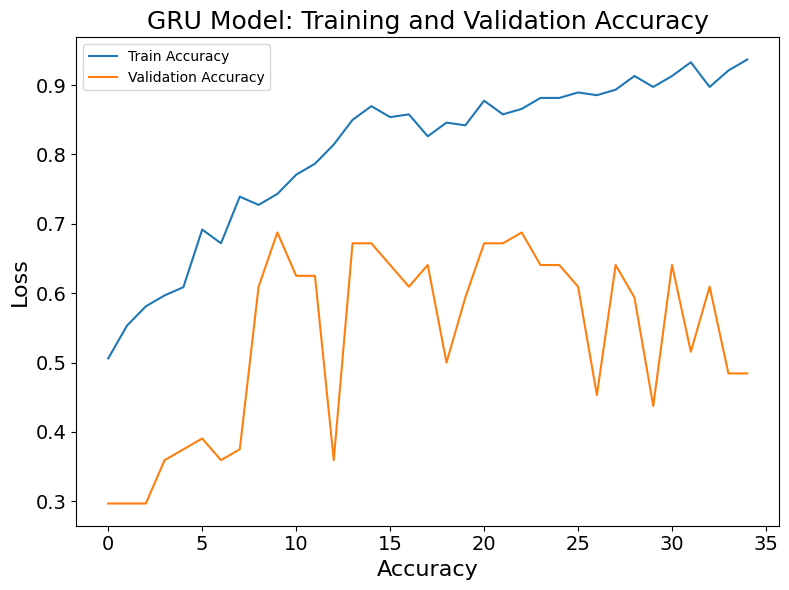

In [ ]:
# Plotting loss train dan validation
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.title('GRU Model: Training and Validation Accuracy', fontsize=18)  # Memperbesar teks judul
plt.xlabel('Accuracy', fontsize=16)  # Memperbesar teks sumbu x
plt.ylabel('Loss', fontsize=16)  # Memperbesar teks sumbu y
plt.xticks(fontsize=14)  # Memperbesar ukuran font ticks sumbu x
plt.yticks(fontsize=14)  # Memperbesar ukuran font ticks sumbu y
plt.legend()
plt.tight_layout()

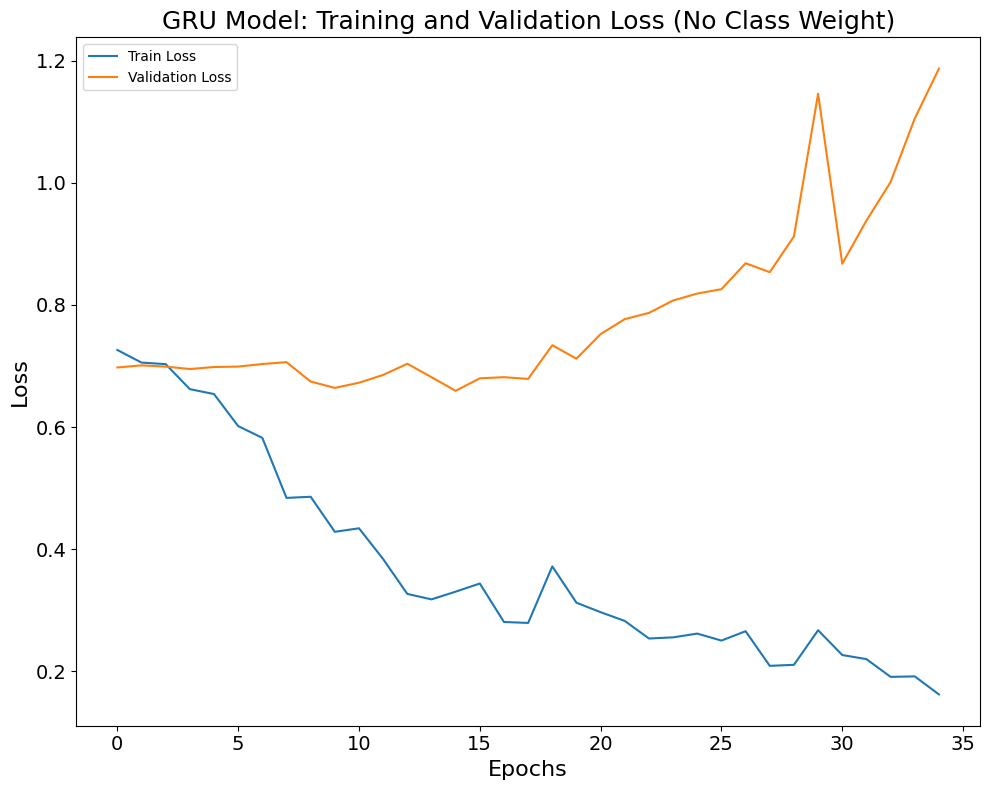

In [ ]:
# Plotting loss train dan validation
plt.figure(figsize=(10, 8))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('GRU Model: Training and Validation Loss (No Class Weight)', fontsize=18)  # Memperbesar teks judul
plt.xlabel('Epochs', fontsize=16)  # Memperbesar teks sumbu x
plt.ylabel('Loss', fontsize=16)  # Memperbesar teks sumbu y
plt.xticks(fontsize=14)  # Memperbesar ukuran font ticks sumbu x
plt.yticks(fontsize=14)  # Memperbesar ukuran font ticks sumbu y
plt.legend()
plt.tight_layout()

In [ ]:
from sklearn.metrics import classification_report

# Prediksi probabilitas
y_pred_prob = model.predict(testing_padded)

# Mengubah probabilitas menjadi kelas biner
y_pred_binary = (y_pred_prob > 0.5).astype(int)

# Tampilkan classification report
print(classification_report(y_test, y_pred_binary))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step
              precision    recall  f1-score   support

           0       0.31      0.58      0.40        19
           1       0.71      0.44      0.55        45

    accuracy                           0.48        64
   macro avg       0.51      0.51      0.47        64
weighted avg       0.59      0.48      0.50        64



In [ ]:
from sklearn.metrics import classification_report

# Prediksi probabilitas
y_pred_prob = model.predict(testing_padded)

# Ubah probabilitas menjadi kelas biner
y_pred_binary = (y_pred_prob > 0.5).astype(int)

# Generate classification report sebagai dictionary
report = classification_report(y_test, y_pred_binary, output_dict=True)

# Ambil nilai-nilai evaluasi dari 'weighted avg'
weighted_precision = report["weighted avg"]["precision"]
weighted_recall = report["weighted avg"]["recall"]
weighted_f1 = report["weighted avg"]["f1-score"]

# Cetak classification report dan metrik yang diambil
print(classification_report(y_test, y_pred_binary))
print(f"Weighted Precision : {weighted_precision:.4f}")
print(f"Weighted Recall    : {weighted_recall:.4f}")
print(f"Weighted F1-score  : {weighted_f1:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
              precision    recall  f1-score   support

           0       0.31      0.58      0.40        19
           1       0.71      0.44      0.55        45

    accuracy                           0.48        64
   macro avg       0.51      0.51      0.47        64
weighted avg       0.59      0.48      0.50        64

Weighted Precision : 0.5929
Weighted Recall    : 0.4844
Weighted F1-score  : 0.5040


## Threshold Tuning

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Range threshold
thresholds = np.arange(0.1, 0.91, 0.05)

# Simpan semua skor per threshold
metrics = []

for t in thresholds:
    y_pred_binary = (y_pred_prob > t).astype(int)

    precision = precision_score(y_test, y_pred_binary, average='weighted')
    recall = recall_score(y_test, y_pred_binary, average='weighted')
    f1 = f1_score(y_test, y_pred_binary, average='weighted')
    acc = accuracy_score(y_test, y_pred_binary)

    metrics.append({
        "threshold": t,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": acc
    })

# Ambil threshold terbaik untuk masing-masing metrik
best_accuracy  = max(metrics, key=lambda x: x["accuracy"])
best_precision = max(metrics, key=lambda x: x["precision"])
best_recall    = max(metrics, key=lambda x: x["recall"])
best_f1        = max(metrics, key=lambda x: x["f1"])

# Cetak hasil terbaik per metrik
print(f"📊 Skor Terbaik per Metrik dan Threshold-nya:")
print(f"✅ Accuracy  : {best_accuracy['accuracy']:.5f} @ threshold = {best_accuracy['threshold']}")
print(f"🎯 Precision : {best_precision['precision']:.5f} @ threshold = {best_precision['threshold']}")
print(f"📈 Recall    : {best_recall['recall']:.5f} @ threshold = {best_recall['threshold']}")
print(f"⚖️  F1-Score  : {best_f1['f1']:.5f} @ threshold = {best_f1['threshold']}")

📊 Skor Terbaik per Metrik dan Threshold-nya:
✅ Accuracy  : 0.71875 @ threshold = 0.1
🎯 Precision : 0.69259 @ threshold = 0.15000000000000002
📈 Recall    : 0.71875 @ threshold = 0.1
⚖️  F1-Score  : 0.69273 @ threshold = 0.15000000000000002


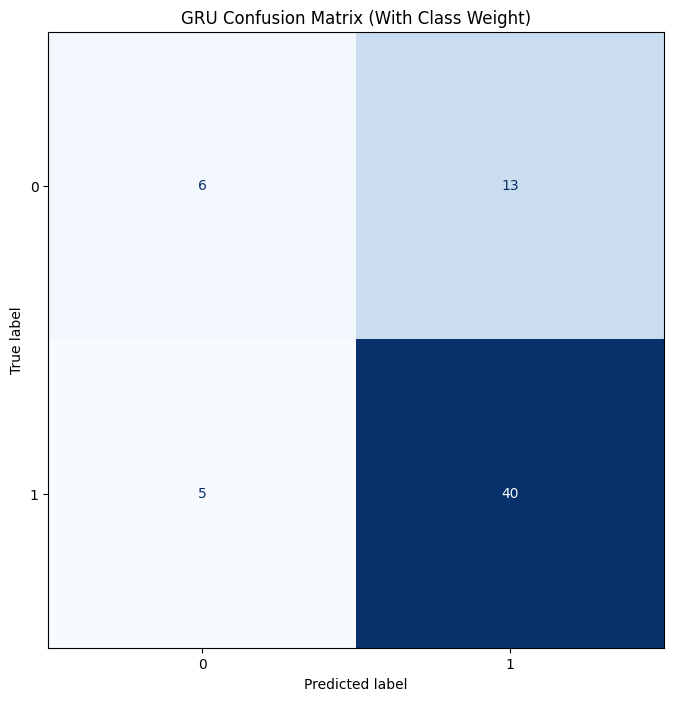

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Ambil threshold terbaik dari F1-Score
best_threshold = best_f1['threshold']
y_pred_best = (y_pred_prob > best_threshold).astype(int)

# Buat confusion matrix
labels = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred_best, labels=labels)

# Visualisasi confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax, cmap='Blues', colorbar=False)

plt.title(f"GRU Confusion Matrix (With Class Weight)")
plt.grid(False)
plt.show()